# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Libraries

In [639]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Reading all Datasets

In [501]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [502]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [503]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [504]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [505]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [506]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [507]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

# Data processing

In [508]:
def clean_portfolio(portfolio):
    '''
    Clean the portfolio dataset:
    - transform the "duration" column to hours
    - one-hot-enconde both channels and offer_type columns
    - rename the "id" column to "offer_id"
    
    INPUT:
    - the original portfolio dataset
    
    OUTPUT:
    - the cleaned portfolio dataset (portfolio_clean) 
    
    '''
    #create a copy
    portfolio_clean = portfolio.copy()
    
    portfolio_clean['offer_id2'] = np.where((portfolio_clean['offer_type'] == 'bogo'), 'Bogo', 
                              np.where((portfolio_clean['offer_type'] == 'discount'), 'Disc', 'Info'))

    portfolio_clean['offer_id2'] = portfolio_clean['offer_type'].map(str) + '-' + portfolio_clean['difficulty'].map(str) + '-' + portfolio_clean['duration'].map(str)
        
    #transform the "duration" column into hours
    portfolio_clean['duration'] = portfolio_clean['duration']*24
    
    #rename "id" column
    portfolio_clean = portfolio_clean.rename(columns={'id': 'offer_id'})

    #one-hot-encode the "channels" column
    portfolio_clean = portfolio_clean.drop('channels', axis = 1).join(portfolio_clean.channels.str.join('|').str.get_dummies())

    #one-hot-enconde the "offer_type" column
    offers_type = pd.get_dummies(portfolio_clean['offer_type'])

    #drop the old "offer_type" column and join dummies
    #portfolio_clean = portfolio_clean.drop('offer_type', axis = 1).join(offers_type)
    portfolio_clean = portfolio_clean.join(offers_type)
    
    return portfolio_clean
    

In [509]:
def clean_profile(profile):
    '''
    Clean the profile dataset:
    - change de dtype for the "became_member_on" to datetime
    - one-hot-enconde the "gender" column
    - rename the "id" column to "user_id"

    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset (profile_clean) 
    
    '''
    #create a copy
    profile_clean = profile.copy()

    #change dtype on the "became_member_on" column to datetime
    profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype(str), format='%Y%m%d')

    #one-hot-enconde the "gender" column
    genders = pd.get_dummies(profile_clean['gender'])
    
    #join dummies
    profile_clean = profile_clean.join(genders)

    #rename the "id" column to "user_id"
    profile_clean = profile_clean.rename(columns={'id': 'user_id'})
    
    return profile_clean
    

In [510]:
def clean_transcript(transcript):
    '''
    Clean the transcript dataset:
    - normalize the "value" column
    - rename "person", "offer id" and "offer_id" columns
    - consolidate all offers ids into one column
    - drop the unnecessary columns 
    - drop the "reward" column --> it will be replaced after the final merge
    
    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset
    
    '''
    #create a copy
    transcript_clean = transcript.copy()
    
    #normalizing dict row into columns
    transcript_clean = transcript_clean.join(pd.json_normalize(transcript_clean.value))  

    #rename columns
    transcript_clean = transcript_clean.rename(columns={'person': 'user_id',
                                                        'offer id': 'offer_id_received',
                                                        'offer_id': 'offer_id_completed'
                                                       }
                                              )
    #get the offer_id data from both columns
    transcript_clean['offer_id'] = np.where(transcript_clean['offer_id_received'].notna() == True,
                                            transcript_clean['offer_id_received'],
                                            transcript_clean['offer_id_completed']
                                           )
    
    #drop columns
    transcript_clean = transcript_clean.drop(columns=['value',
                                                      'reward',
                                                      'offer_id_received',
                                                      'offer_id_completed'],
                                             axis = 1
                                            )
    
    #one-hot-enconde the "event" column
    events = pd.get_dummies(transcript_clean['event'])

    #join dummies
    transcript_clean = transcript_clean.join(events)
    
    return transcript_clean


In [511]:
portfolio_df = clean_portfolio(portfolio)
transcript_df = clean_transcript(transcript)
profile_df = clean_profile(profile)

In [512]:
portfolio_df.head()

,reward,difficulty,duration,offer_type,offer_id,offer_id2,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10-7,1,1,1,0,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10-5,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,informational-0-4,1,1,0,1,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-7,1,1,0,1,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-10,1,0,0,1,0,1,0


In [513]:
transcript_df.head()

,user_id,event,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [514]:
transcript_df.describe()

,time,amount,offer completed,offer received,offer viewed,transaction
count,306534.000000,138953.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,12.777356,0.109544,0.248837,0.188315,0.453304
std,200.326314,30.250529,0.312321,0.432340,0.390964,0.497815
min,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,2.780000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,8.890000,0.000000,0.000000,0.000000,0.000000
75%,528.000000,18.070000,0.000000,0.000000,0.000000,1.000000
max,714.000000,1062.280000,1.000000,1.000000,1.000000,1.000000


In [515]:
profile_df.head()

,gender,age,user_id,became_member_on,income,F,M,O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0


In [516]:
profile_df.describe()

,age,income,F,M,O
count,17000.000000,14825.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,0.360529,0.499059,0.012471
std,26.738580,21598.299410,0.480168,0.500014,0.110977
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,45.000000,49000.000000,0.000000,0.000000,0.000000
50%,58.000000,64000.000000,0.000000,0.000000,0.000000
75%,73.000000,80000.000000,1.000000,1.000000,0.000000
max,118.000000,120000.000000,1.000000,1.000000,1.000000


In [517]:
def final_merge(portfolio_df, transcript_df, profile_df):
    '''
    Merge all cleaned datasets into one
    
    INPUT:
    portfolio_df - cleaned portfolio df
    transcript_df - cleaned transcript df
    profile_df - cleaned profile df
    
    OUTPUT:
    df - final df merged with all 3 datasets
    
    '''
    
    #merge transcript and profile
    df = transcript_df.merge(profile_df, how='left', on='user_id')
    
    #merge transcript and portfolio
    df = df.merge(portfolio_df, how='left', on='offer_id')
       
    #sort dataframe by user_id and offer_id
    df = df.sort_values(['user_id', 'offer_id'], ascending=False)
    
    #drop all nan values
    df = df[df['income'].notna()]
    
    #drop old offer_id column and replace it
    df = df.drop(columns=['offer_id'])
    df = df.rename(columns={'offer_id2': 'offer_id'})
    
    #create age group column
    df['age_group'] = pd.cut(df['age'], 
                             bins=[18, 25, 35, 45, 55, 65, 75, 85, 95, 105],
                            labels=['18-25', '26-35', '36-45', '46-55', '56-65',
                            '66-75', '76-85', '86-95', '96+'])
    
    #one-hot-enconde the "age_group" column
    age_group = pd.get_dummies(df['age_group'])
    
    #join dummies
    df = df.drop('age_group', axis=1).join(age_group)
    
    return df

In [518]:
df = final_merge(portfolio_df, transcript_df, profile_df)

# Identifying a successful offer

1. An offer is considered a **successful** if the following steps are made:
    - *Offer Received -> View Offer -> Complete Offer*
    <p> </p>
2. An offer is considered **unsuccessful** in the following situations:
    - *Offer Received*
    - *Offer Received -> View Offer*
    - *Offer Received -> Complete Offer -> View Offer*
    - *Offer Received -> Complete Offer*

In [519]:
def bogo_offers(df=df):
    
    '''
    Identifies bogo offers that were successful and unsuccessful
    
    INPUT:
    df - cleaned and merged dataframe
    
    OUTPUT:
    bogo_sucess - all sucessful bogo offers
    bogo_not_sucess - all unsucessful bogo offers
    bogo_offers - merged df with successful and not successful offers
    '''

    #df with bogo offers and transactions
    bogo = df[(df['offer_type'] == 'bogo')]
    
    #offset just the necessary columns
    bogo = bogo[['user_id', 'duration', 'offer received', 'offer viewed', 'offer completed',
                 'offer_type', 'offer_id', 'time', 'difficulty', 'reward', 'F', 'M', 'O',
                 'age', 'gender', 'income', 'became_member_on',
                 'event', 'email', 'mobile', 'web', 'social', 
                 '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95', '96+']]
    
    #replace white space for underline in the column name
    bogo.columns = bogo.columns.str.strip().str.replace('\s+', '_')
    
    #sort values by users and time (this make every transaction to be below the completed offer)
    bogo = bogo.sort_values(['user_id', 'time'], ascending=True)

    #create a time_limit column
    bogo['time_limit'] = bogo['time'] + bogo['duration']

    #create a unique column for suport
    bogo['conc'] = bogo['user_id'] + bogo['offer_id']

    #In order to achieve the offer, the user must follow the sequence:
    #received -> viewed -> completed
    
    #identify if is a received offer row
    #check if its the same user+offer_id on row below
    #check if its a offer_viewed
    #set the column "offer_view" in the row to 1
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-1) ) &
                ( bogo.offer_viewed.shift(-1) == 1 ),
                ['offer_viewed'] ] = bogo.offer_viewed.shift(-1)

    #time_viewed
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-1) ) &
                ( bogo.offer_viewed.shift(-1) == 1 ),
                ['time_viewed'] ] = bogo.time.shift(-1)

    #identify if is a received offer row
    #check if its the same user+offer_id on 2 rows below
    #check if its a offer_completed
    #set the column "offer_completed" in the row to 1
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-2) ) &
                ( bogo.offer_completed.shift(-2) == 1 ),
                ['offer_completed'] ] = bogo.offer_completed.shift(-2)

    #time_completed
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-2) ) &
                ( bogo.offer_completed.shift(-2) == 1 ),
                ['time_completed'] ] = bogo.time.shift(-2)

    #create a empty amount column
    bogo['amount'] = 0
    
    #create a 'True' and 'False' for 'sucess'    
    bogo['sucess'] = np.where(((bogo['offer_received'] == 1) & 
                               (bogo['offer_viewed'] == 1) & 
                               (bogo['offer_completed'] == 1)
                              ), 1, 0
                             )   
    
    #subset just user+offer with received, view and completed equals to 1
    bogo_not_sucess = bogo[bogo['sucess'] == 0]
    bogo_sucess = bogo[bogo['sucess'] == 1]
    
    #create new df only with transactions
    transactions = df[df['event'] == 'transaction']

    #offset just necessary columns
    transactions = transactions[['user_id', 'time', 'amount']]

    #find common users between both dataframes
    common_users = np.intersect1d(bogo_sucess['user_id'], transactions['user_id'])

    #select only transactions for users that received, viewed and completed offers
    transactions = transactions[transactions.user_id.isin(common_users)]

    #reset index
    bogo_sucess = bogo_sucess.reset_index().drop('index', axis = 1)
    bogo_sucess.index = np.arange(1,len(bogo_sucess)+1)   
    
    #for all users
    for index in bogo_sucess.index:
        #Identify the same user in both dataframes +
        #check if the transaction was made between the time received and time completed
        #sum the amount and save in the "amount" column
        bogo_sucess['amount'][index] = transactions.loc[ (transactions.user_id == bogo_sucess['user_id'][index]) & 
                                        (transactions.time == bogo_sucess['time_completed'][index])
                                                       ]['amount'].sum()

    #create aux coloumns
    bogo_sucess['conc1'] = bogo_sucess['conc'] + 'offer viewed' + bogo_sucess['time_viewed'].map(str)
    bogo_sucess['conc2'] = bogo_sucess['conc'] + 'offer completed' + bogo_sucess['time_completed'].map(str)

    #create aux coloumns    
    bogo_not_sucess['time'] = bogo_not_sucess['time'].astype('float64')
    bogo_not_sucess['conc1'] = bogo_not_sucess['conc'] + bogo_not_sucess['event'] + bogo_not_sucess['time'].map(str)
    bogo_not_sucess['conc2'] = bogo_not_sucess['conc'] + bogo_not_sucess['event'] + bogo_not_sucess['time'].map(str)

    #check for similarity between the two auxiliaries columns
    common = np.intersect1d(bogo_sucess['conc1'], bogo_not_sucess['conc1'])
    common2 = np.intersect1d(bogo_sucess['conc2'], bogo_not_sucess['conc2'])
    
    #pick all not sucess
    bogo_not_sucess  = bogo_not_sucess[~bogo_not_sucess.conc1.isin(common)]
    bogo_not_sucess  = bogo_not_sucess[~bogo_not_sucess.conc2.isin(common2)]
    
    #offset just the not sucess offers
    bogo_not_sucess = bogo_not_sucess[bogo_not_sucess['offer_received'] == 1]            

    #Concat both dfs
    bogo_offers = pd.concat([bogo_sucess, bogo_not_sucess])

    return bogo_sucess, bogo_not_sucess, bogo_offers

In [520]:
def discount_offers(df=df):
    
    '''
    Identifies discount offers that were successful and unsuccessful
    
    INPUT:
    df - cleaned and merged dataframe
    
    OUTPUT:
    discount_sucess - all sucessful discount offers
    discount_not_sucess - all unsucessful discount offers
    discount_offers - merged df with successful and not successful offers
    '''
       
    #select just discount offers   
    discount = df[(df['offer_type'] == 'discount')]
                         
    #offset just the necessary columns
    discount = discount[['user_id', 'duration', 'offer received', 'offer viewed', 'offer completed',
                         'offer_type', 'offer_id', 'time', 'difficulty', 'reward', 'F', 'M', 'O',
                         'age', 'gender', 'income', 'became_member_on',
                         'event', 'email', 'mobile', 'web', 'social', 
                        '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95', '96+']]
    
    #replace white space for underline in the column name
    discount.columns = discount.columns.str.strip().str.replace('\s+', '_')
       
    #sort values
    discount = discount.sort_values(['user_id', 'time'], ascending=True)
    
    #create a limit column if offer received = True
    discount['time_limit'] = discount['time'] + discount['duration']
                         
    #create a unique column for futher aux
    discount['conc'] = discount['user_id'] + discount['offer_id']
    
    #In order to achieve the offer, the user must follow the sequence:
    #received -> viewed -> completed
    
    #identify if is a received offer row
    #check if its the same user+offer_id on row below
    #check if its a offer_viewed
    #set the column "offer_view" in the row to 1
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-1) ) &
               ( discount.offer_viewed.shift(-1) == 1 ),
               ['offer_viewed'] ] = discount.offer_viewed.shift(-1)

    #time_viewed
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-1) ) &
               ( discount.offer_viewed.shift(-1) == 1 ),
               ['time_viewed'] ] = discount.time.shift(-1)

    #identify if is a received offer row
    #check if its the same user+offer_id on 2 rows below
    #check if its a offer_completed
    #set the column "offer_completed" in the row to 1
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-2) ) &
               ( discount.offer_completed.shift(-2) == 1 ),
               ['offer_completed'] ] = discount.offer_completed.shift(-2)

    #time_completed
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-2) ) &
               ( discount.offer_completed.shift(-2) == 1 ),
               ['time_completed'] ] = discount.time.shift(-2)
    
    #create a empty amount column
    discount['amount'] = 0
    
    #create a 'True' and 'False' for 'sucess'    
    discount['sucess'] = np.where(((discount['offer_received'] == 1) & 
                                   (discount['offer_viewed'] == 1) & 
                                   (discount['offer_completed'] == 1)
                                  ), 1, 0
                                 )  
       
    #subset just user+offer with received, view and completed equals to 1
    discount_not_sucess = discount[discount['sucess'] == 0]
    discount_sucess = discount[discount['sucess'] == 1]
    
    #create new df only with transactions
    transactions = df[df['event'] == 'transaction']
    
    #offset just necessary columns
    transactions = transactions[['user_id', 'time', 'amount']]
    
    #find common users between both dataframes
    common_users = np.intersect1d(discount['user_id'], transactions['user_id'])
    
    #select only transactions for users that received, viewed and completed offers
    transactions  = transactions[transactions.user_id.isin(common_users)]
    
    #reset index
    discount_sucess = discount_sucess.reset_index().drop('index', axis = 1)
    discount_sucess.index = np.arange(0,len(discount_sucess))
    
    #for all users 
    for index in discount_sucess.index:
        #Identify the same user in both dataframes +
        #check if the transaction was made between the time received and time completed
        #sum the amount and save in the "amount" column
        discount_sucess['amount'][index] = transactions.loc[ (transactions.user_id == discount_sucess['user_id'][index]) & 
                                                            (transactions.time >= discount_sucess['time'][index]) &
                                                            (transactions.time <= discount_sucess['time_completed'][index])
                                                           ]['amount'].sum()
   
    #create aux coloumns
    discount_sucess['conc1'] = discount_sucess['conc'] + 'offer viewed' + discount_sucess['time_viewed'].map(str)
    discount_sucess['conc2'] = discount_sucess['conc'] + 'offer completed' + discount_sucess['time_completed'].map(str)
    
    #create aux columns
    discount_not_sucess['time'] = discount_not_sucess['time'].astype('float64')
    discount_not_sucess['conc1'] = discount_not_sucess['conc'] + discount_not_sucess['event'] + discount_not_sucess['time'].map(str)
    discount_not_sucess['conc2'] = discount_not_sucess['conc'] + discount_not_sucess['event'] + discount_not_sucess['time'].map(str)

    #check for similarity between the two auxiliaries columns
    common = np.intersect1d(discount_sucess['conc1'], discount_not_sucess['conc1'])
    common2 = np.intersect1d(discount_sucess['conc2'], discount_not_sucess['conc2'])
    
    #pick all not sucess
    discount_not_sucess  = discount_not_sucess[~discount_not_sucess.conc1.isin(common)]
    discount_not_sucess  = discount_not_sucess[~discount_not_sucess.conc2.isin(common2)]
    
    #offset just the not sucess offers
    discount_not_sucess = discount_not_sucess[discount_not_sucess['offer_received'] == 1]
    
    #Concat both dfs
    discount_offers = pd.concat([discount_sucess, discount_not_sucess])
        
    return discount_sucess, discount_not_sucess, discount_offers

In [521]:
discount_sucess, discount_not_sucess, discount_offers = discount_offers()

In [522]:
bogo_sucess, bogo_not_sucess, bogo_offers = bogo_offers()

In [523]:
final_df = pd.concat([discount_offers, bogo_offers])

In [524]:
def roi(discount_sucess=discount_sucess, bogo_sucess=bogo_sucess):
    
    '''
    Calculate de return over investiment for sucess offers
    Its offset just offers that have a +- 1.5 sd in the column amount
    since we have a few outliers in our original dataframe
    
    INPUT:
    - discount_sucess df
    - bogo_sucess df
      
    OUTPUT:
    - return a new df with sum amount, difficulty (investiment), and ROI
    
    '''
    
    #keep only the ones that are within +1.5 to -1.5 standard deviations in the column 'amount'.
    discount_sucess = discount_sucess[np.abs(discount_sucess.amount-df.amount.mean()) <= (1.5*discount_sucess.amount.std())]
    bogo_sucess = bogo_sucess[np.abs(bogo_sucess.amount-df.amount.mean()) <= (1.5*bogo_sucess.amount.std())]
    
    #sum the difficulty (total expanse for the offer) and the amount (value received for each sucess offer)
    roi_discount = discount_sucess.groupby('offer_id', as_index=False)['amount', 'difficulty'].sum()
    roi_bogo = bogo_sucess.groupby('offer_id', as_index=False)['amount', 'difficulty'].sum()
    
    #concat
    roi_df = pd.concat([roi_discount, roi_bogo])
    
    #calculate ROI
    roi_df['ROI'] = (roi_df['amount'] - roi_df['difficulty']) / roi_df['difficulty']
     
    return roi_df

In [525]:
roi_df = roi(discount_sucess, bogo_sucess)

# Data Anaylsis

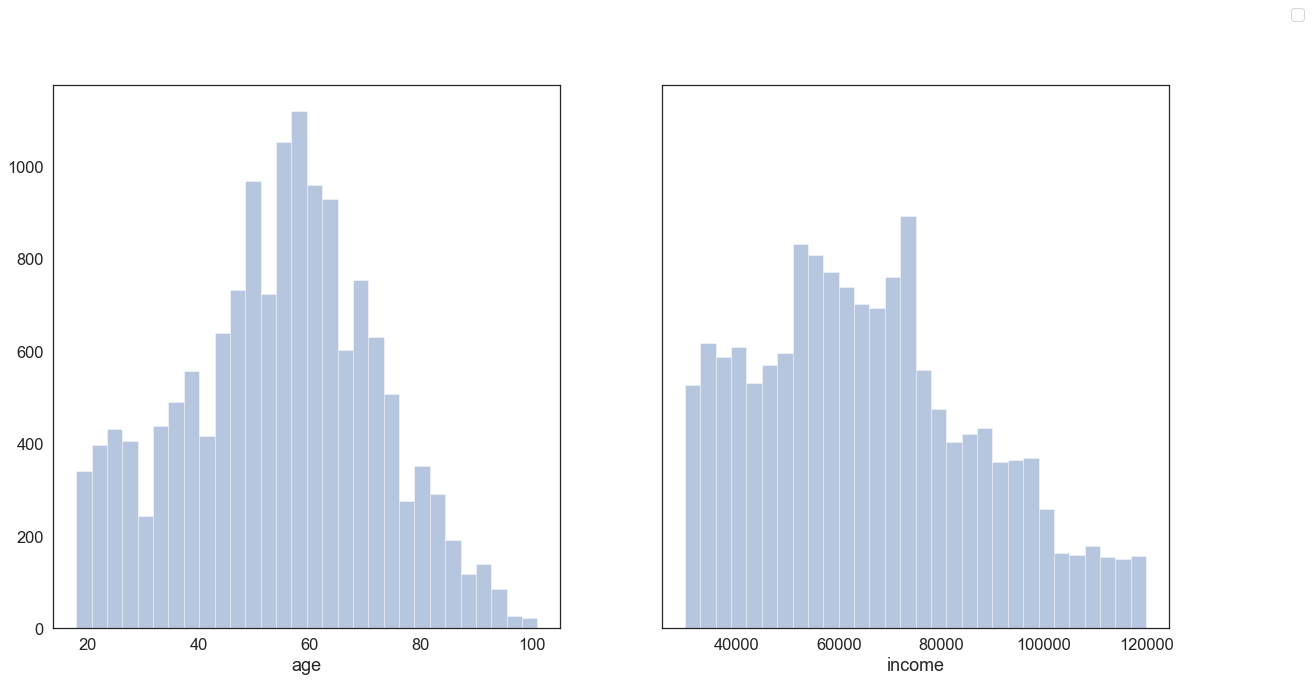

In [526]:
#users age and income
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(20,10)
fig.legend(['abacaxi', 'banana'])

#plot income histogram
income_hist = df.groupby(['user_id'])['age'].mean()
sns.distplot(income_hist,ax=ax[0], kde=False, bins=30);

#plot income histogram
income_hist = df.groupby(['user_id'])['income'].mean()
sns.distplot(income_hist, ax=ax[1], kde=False, bins=30);

#plt.savefig('./figures/user_demograph.png')

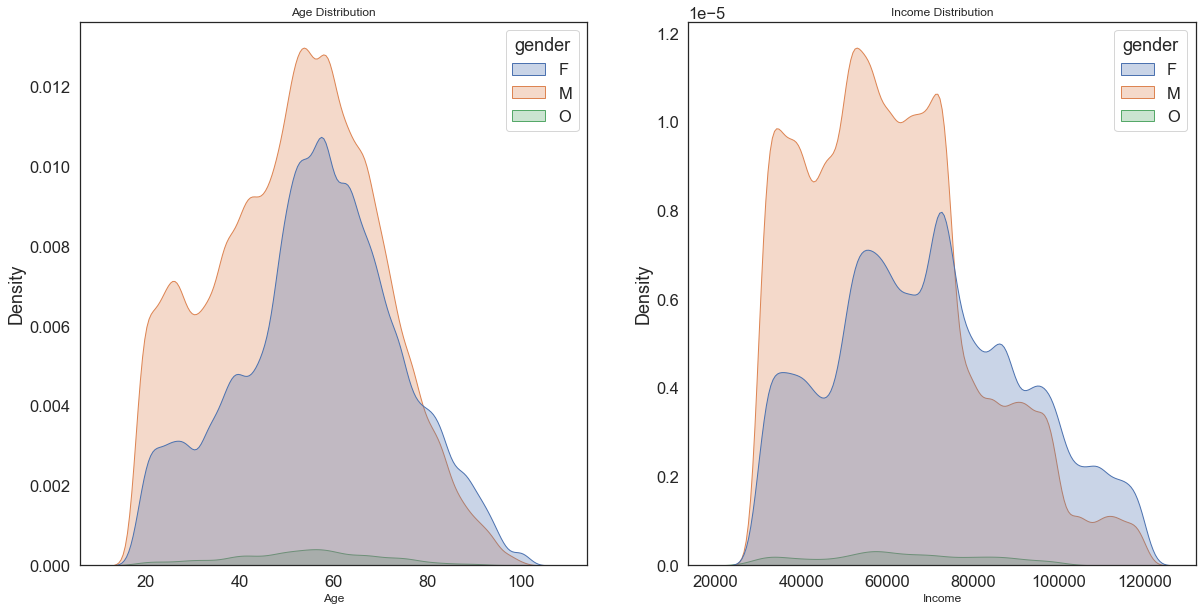

In [527]:
#age and income distribuction by gender
fig, ax = plt.subplots(1,2)

fig.set_size_inches(20,10)

sns.kdeplot(data=df, x='age', hue='gender', fill=True, ax=ax[0], alpha=0.3)
ax[0].set_title('Age Distribution', fontsize=12)
ax[0].set_xlabel('Age', fontsize=12)

sns.kdeplot(data=df, x='income', hue='gender', fill=True, ax=ax[1], alpha=0.3)
ax[1].set_title('Income Distribution', fontsize=12)
ax[1].set_xlabel('Income', fontsize=12)

#plt.savefig('./figures/gender_distribuition.png')

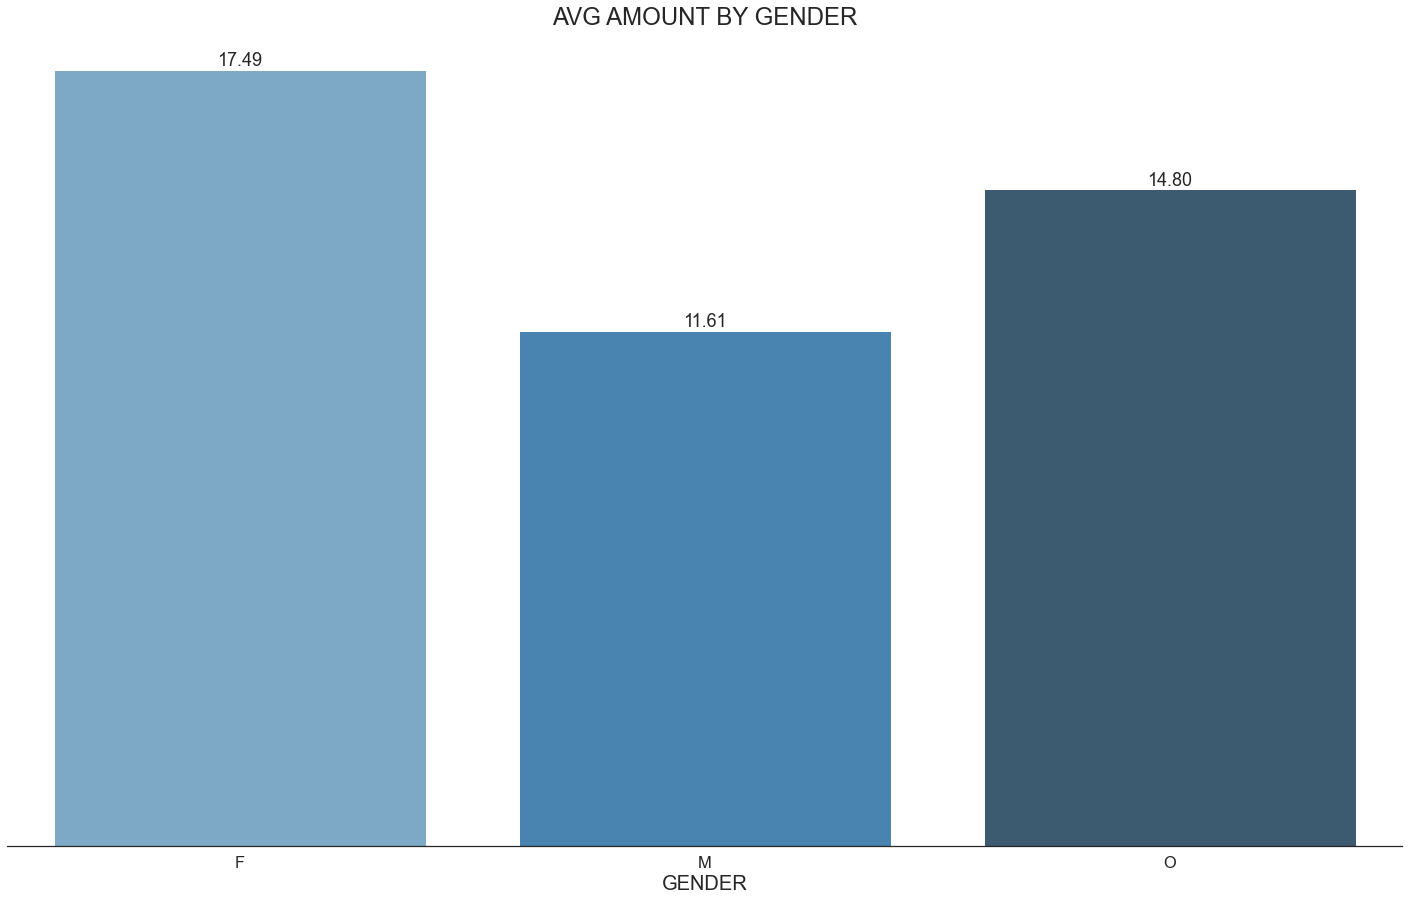

In [528]:
#show the sucess rate by offer x gender
plt.figure(figsize=(25, 15))

#plot
splot = sns.barplot(data=df, x='gender', y='amount', palette='Blues_d', ci=False)

#labels and title
plt.xlabel('GENDER', fontsize=20) #set the xlabel
plt.title('AVG AMOUNT BY GENDER', fontsize=24) #set the title

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels
    
#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
#plt.savefig('./figures/avg_amount_by_gender.png') #save fig

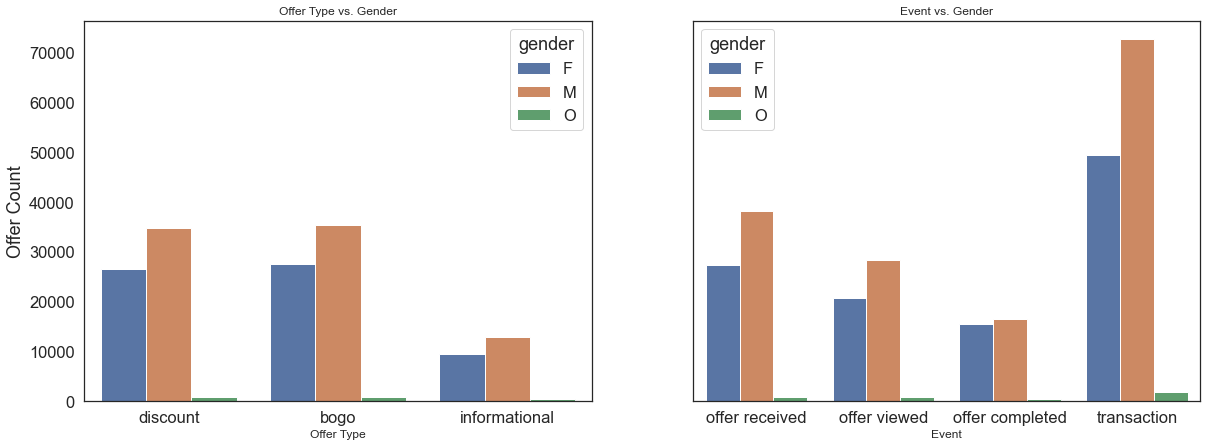

In [529]:
#how offers were divided between users for each offer_type and how they react to then
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(20,7)

sns.countplot(data=df, x='offer_type', hue='gender', ax=ax[0])
ax[0].set_title('Offer Type vs. Gender', fontsize=12)
ax[0].set_xlabel('Offer Type', fontsize=12)
ax[0].set_ylabel('Offer Count')

sns.countplot(data=df, x='event', hue='gender', ax=ax[1])
ax[1].set_title('Event vs. Gender', fontsize=12)
ax[1].set_xlabel('Event', fontsize=12)
ax[1].set_ylabel(' ')

#plt.savefig('./figures/offer_vs_gender.png')

### Organizing some dataframes to plot some charts 

In [530]:
#sorting the roi_df
roi_df = roi_df.sort_values('ROI', ascending=False)

#create a new df to see the sucessfull rate offers by gender
gender_offer_sucess = final_df.groupby(['gender', 'offer_id'], as_index=False)['sucess'].mean().sort_values('sucess', ascending=False)
gender_offer_sucess = gender_offer_sucess[gender_offer_sucess['gender'] != 'O']

#create a new df to see the sucessfull rate by offer_id
offer_sucess = final_df.groupby('offer_id', as_index=False)['sucess'].mean().sort_values('sucess', ascending=False)

#create a new df to see the sucessfull rate by age group
gender_age_sucess = final_df.groupby(['gender', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95', '96+'], as_index=False)['sucess'].mean()
gender_age_sucess = pd.melt(gender_age_sucess, id_vars=['gender', 'sucess'], value_vars=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95', '96+'])
gender_age_sucess = gender_age_sucess[(gender_age_sucess['gender'] != 'O') & (gender_age_sucess['value'] == 1)].sort_values('sucess', ascending=False)

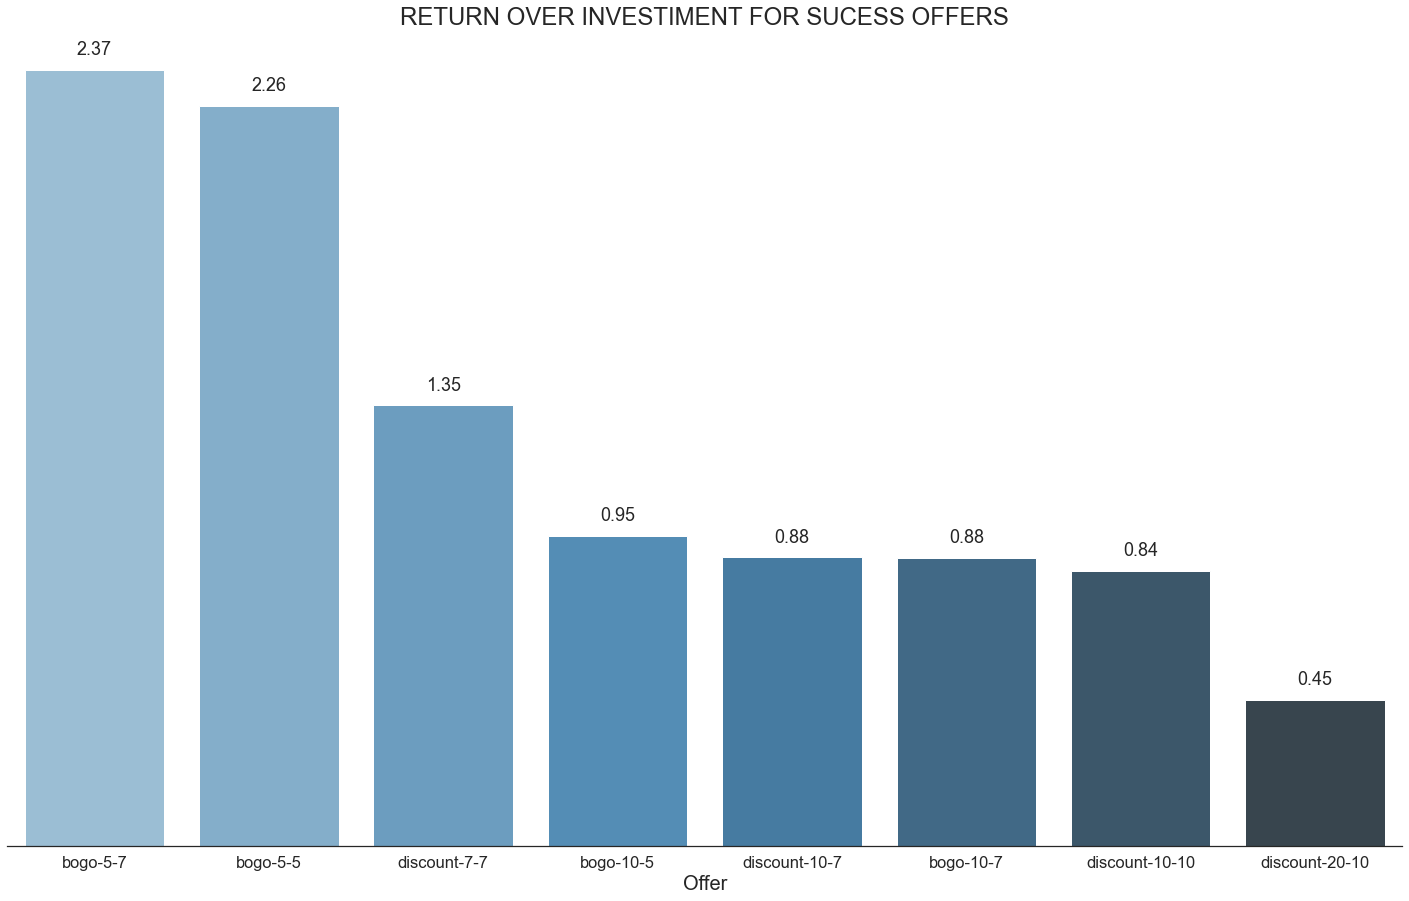

In [531]:
#show ROI for sucess offers
plt.figure(figsize=(25, 15))

#plot
splot = sns.barplot(data=roi_df, x='offer_id', y='ROI', palette='Blues_d', ci=False)

#labels and title
plt.xlabel('Offer', fontsize=20) #set the xlabel
plt.title('RETURN OVER INVESTIMENT FOR SUCESS OFFERS', fontsize=24) #set the title

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), 
                   textcoords = 'offset points')
    
#plt.savefig('./figures/offer_sucess_roi.png') #save fig

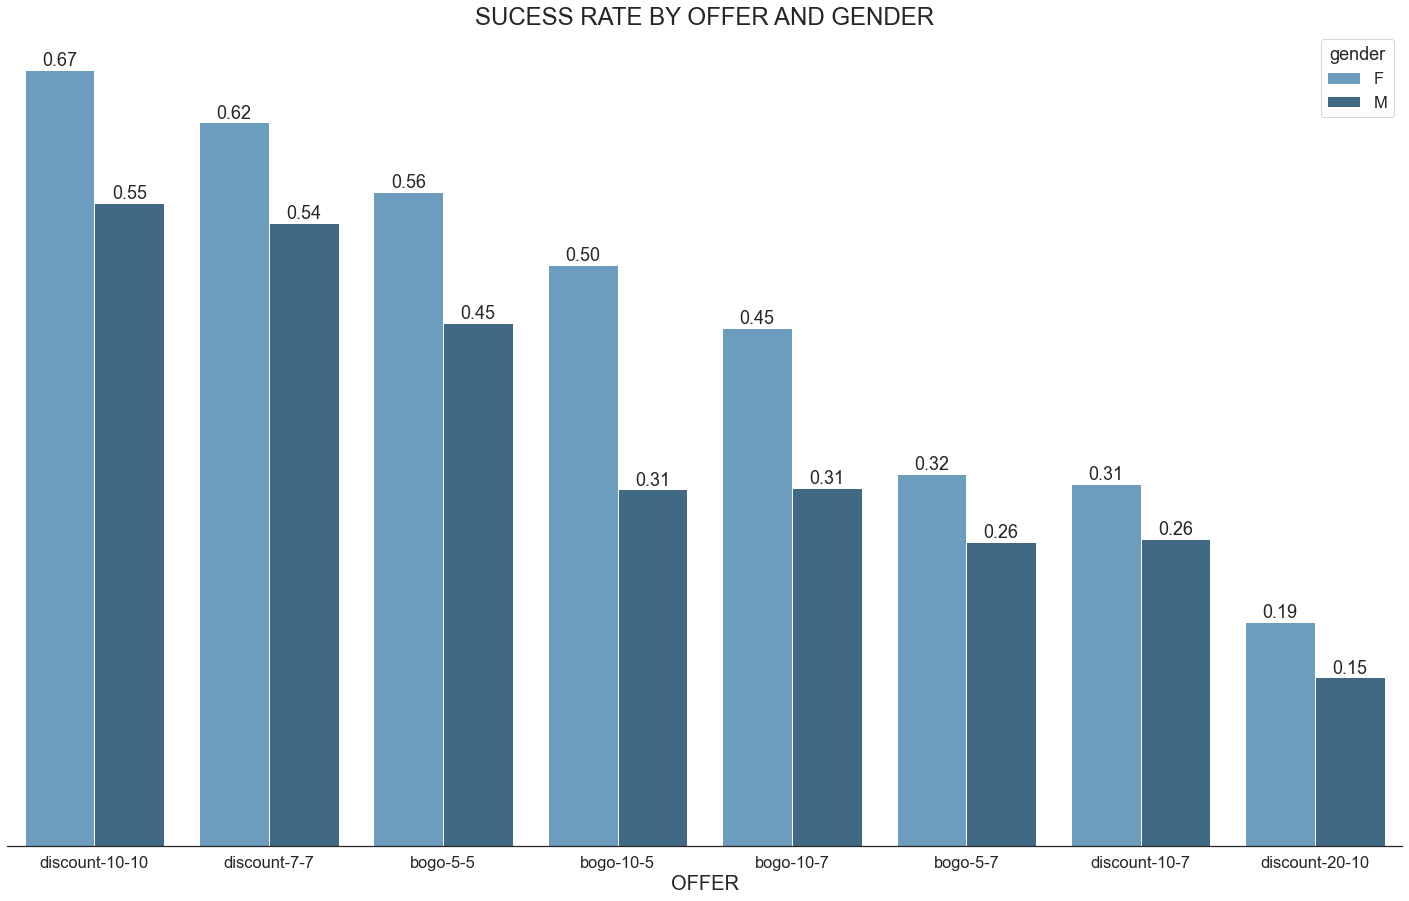

In [532]:
#show the sucess rate by offer x gender
plt.figure(figsize=(25, 15))

#plot
splot = sns.barplot(data=gender_offer_sucess, x='offer_id', y='sucess', hue='gender' , palette='Blues_d', ci=False)

#labels and title
plt.xlabel('OFFER', fontsize=20) #set the xlabel
plt.title('SUCESS RATE BY OFFER AND GENDER', fontsize=24) #set the title

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
#plt.savefig('./figures/offer_gender_sucess.png') #save fig

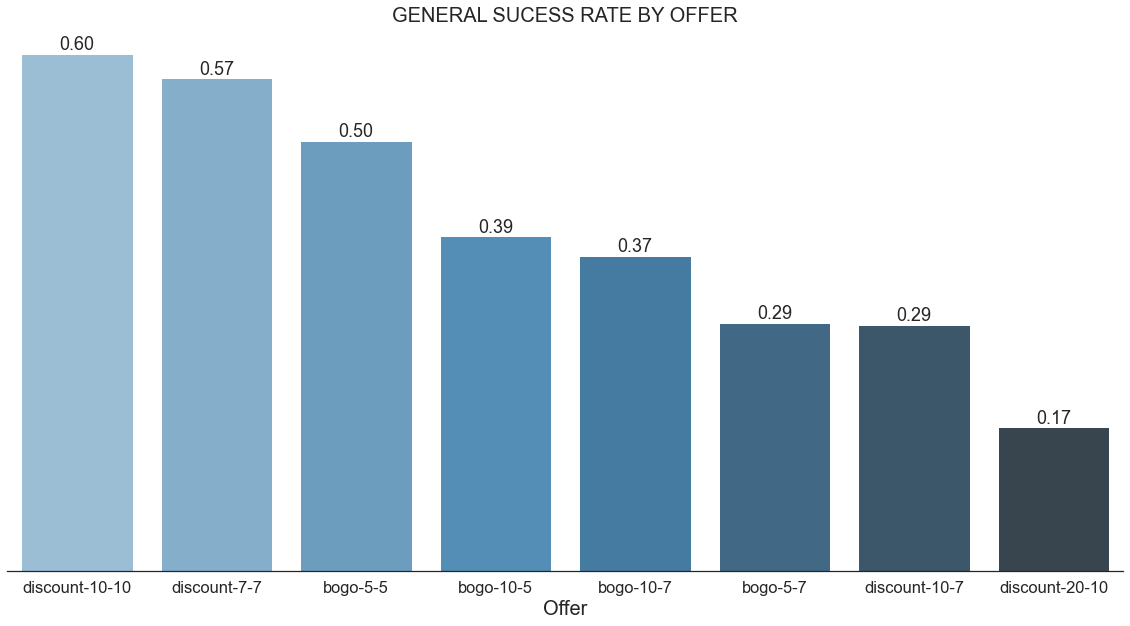

In [533]:
#show the sucess rate by offer
plt.figure(figsize=(20, 10))

#plot
splot = sns.barplot(data=offer_sucess, x='offer_id', y='sucess', palette='Blues_d',ci=False)

#labels and title
plt.xlabel('Offer', fontsize=20)
plt.title('GENERAL SUCESS RATE BY OFFER', fontsize=20)

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
#plt.savefig('./figures/offer_sucess.png')

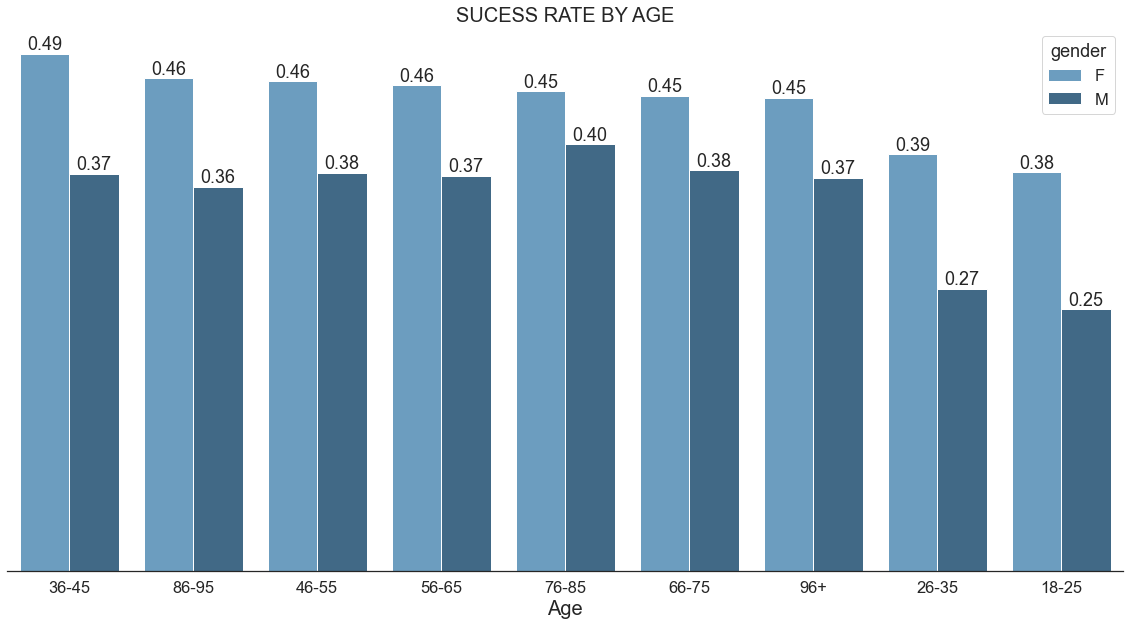

In [534]:
#show the sucess rate by offer
plt.figure(figsize=(20, 10))

#plot
splot = sns.barplot(data=gender_age_sucess, x='variable', y='sucess', hue='gender', palette='Blues_d',ci=False)

#labels and title
plt.xlabel('Age', fontsize=20)
plt.title('SUCESS RATE BY AGE', fontsize=20)

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
#plt.savefig('./figures/gender_age_sucess.png')

# MODELOS DE CLASSIFICAÇÃO

I started by looking at a correlation matrix between the main features of the final matrix. Some were withdrawn, as it was identified that they participated in 100% of the hypotheses - *** offer_received and email ***.

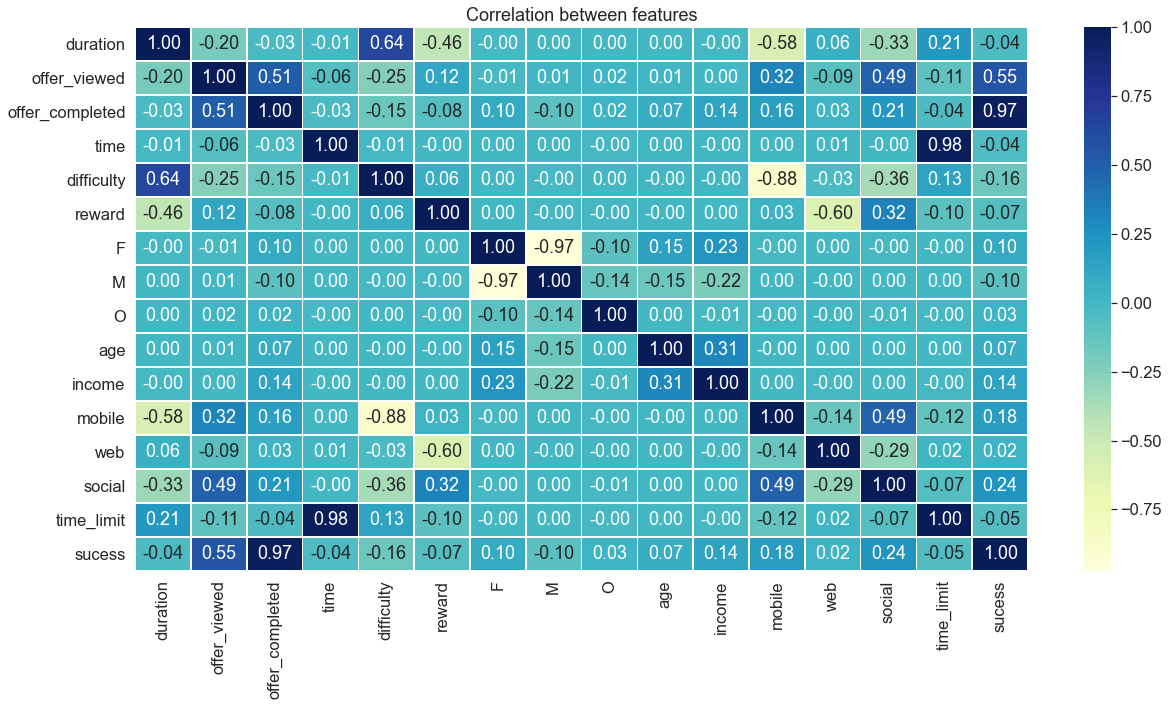

In [535]:
correlacao = final_df[['user_id', 'duration', 'offer_viewed',
                       'offer_completed', 'offer_type', 'offer_id', 'time', 'difficulty',
                        'reward', 'F', 'M', 'O', 'age', 'income', 'became_member_on', 'event',
                        'mobile', 'web', 'social', 'time_limit', 'sucess']]

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)

sns.heatmap(correlacao.corr(),
            annot = True,
            fmt = '.2f',
            linewidths=.8,
            cmap='YlGnBu')

plt.title('Correlation between features')

#plt.savefig('./figures/correlation_matrix.png')

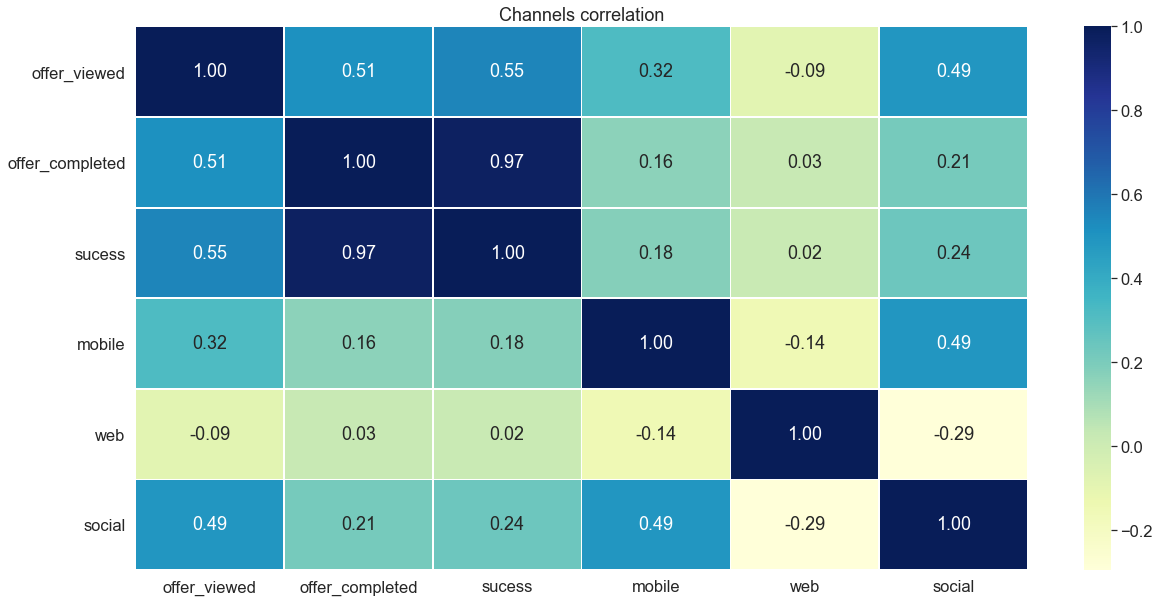

In [536]:
correlacao = final_df[['offer_viewed', 'offer_completed', 'sucess',
                        'mobile', 'web', 'social']]

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
sns.heatmap(correlacao.corr(),
            annot = True,
            fmt = '.2f',
            linewidths=.8,
            cmap='YlGnBu')

plt.title('Channels correlation')

#plt.savefig('./figures/correlation_channels.png')

In [641]:
def classification_model(df, target, model):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable ('sucess' column)
    model - the model used for prediction
    
    OUTPUT:
    model - the classification model
    features importance plot - chart with the most important features
    '''
    
    #selecting the features do analyse   
    X = df[['offer_type', 'duration', 'time', 'difficulty', 'reward',
            'age', 'F', 'M', 'O', 'income',
            'web', 'mobile', 'social']]
    
    #create dummies for all offers
    offer_dummies = pd.get_dummies(X['offer_type'])
    
    #insert the offers dummies and drop the offer_type column
    X = pd.concat([X.drop('offer_type', axis=1), offer_dummies], axis=1)
    
    #set the target column - it should be the 'Sucess'
    y = df[target]
    
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #select the model, fit and predict
    model = model #variable for the model
    model.fit(X_train, y_train) #fit the model
    y_pred = model.predict(X_test) #predict the model
    print(classification_report(y_test, y_pred))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, y_pred)))
    print("Overall model F1-Score:\t {}".format(f1_score(y_test, y_pred)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
       
    #plots
    fig, ax = plt.subplots(2,1)
    
    fig.set_size_inches(10,10)
    
    #plot feature_importances
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plot = sns.barplot(x=importances, y=X.columns, orient='h', ax=ax[0]).set_title('Features Importance')
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion = sns.heatmap(cm, annot=True, ax=ax[1], fmt='g')
    
    #cross validation
    kfold = StratifiedKFold(n_splits=10)
    results = cross_val_score(model, X, y, cv=kfold)
    print("kfold Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    return model, plot, confusion

#### Os seguintes modelos foram testados:

1. RandomForestClassifier
2. GradientBoostingClassifier
3. AdaBoostClassifier

In [628]:
final_df['sucess'].value_counts()

0    32132
1    21069
Name: sucess, dtype: int64

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      9502
           1       0.53      0.48      0.50      6459

    accuracy                           0.62     15961
   macro avg       0.60      0.60      0.60     15961
weighted avg       0.61      0.62      0.62     15961

Overall model accuracy:	 0.6186955704529792
Overall model F1-Score:	 0.5048006509357201
Train ROC AUC score:	 0.9992068777158848
Test ROC AUC score:	 0.6491679345608551
kfold Accuracy: 61.88% (2.55%)


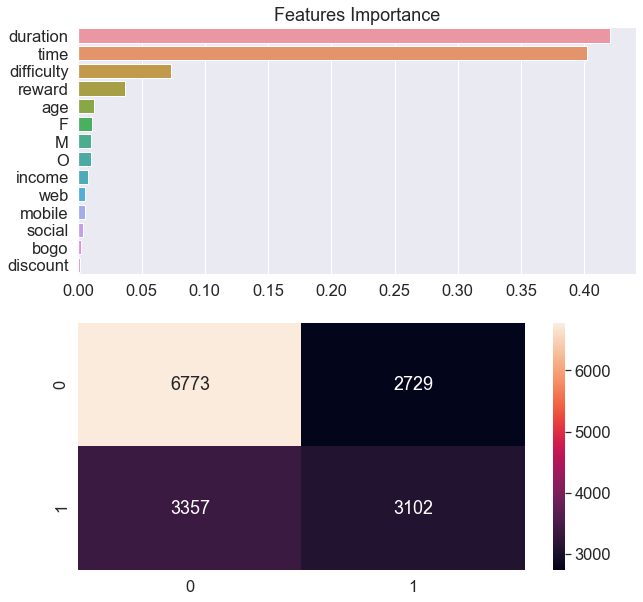

In [645]:
#execute the classification model with the RandomForestClassifier
rfc = classification_model(final_df, 'sucess', RandomForestClassifier(random_state=42))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.48      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6666875509053317
Overall model F1-Score:	 0.5387549852609675
Train ROC AUC score:	 0.7188207143274103
Test ROC AUC score:	 0.7163737809095136
kfold Accuracy: 66.62% (2.69%)


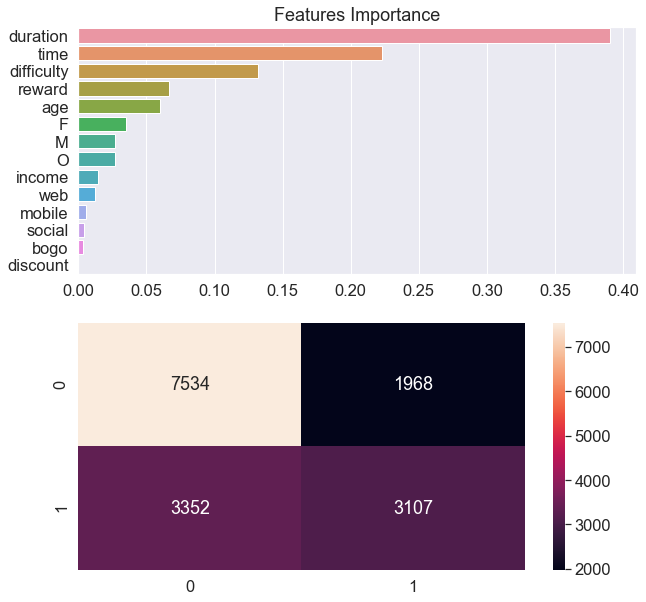

In [644]:
#execute the classification model with the GradientBoostingClassifier
gbc = classification_model(final_df, 'sucess', GradientBoostingClassifier(random_state=42))

In [540]:
#get model params keys
model = GradientBoostingClassifier(random_state=42)
model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.43      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6632416515255937
Overall model F1-Score:	 0.5100720080211466
Train ROC AUC score:	 0.704479002299589
Test ROC AUC score:	 0.7080889889495807
kfold Accuracy: 66.16% (2.76%)


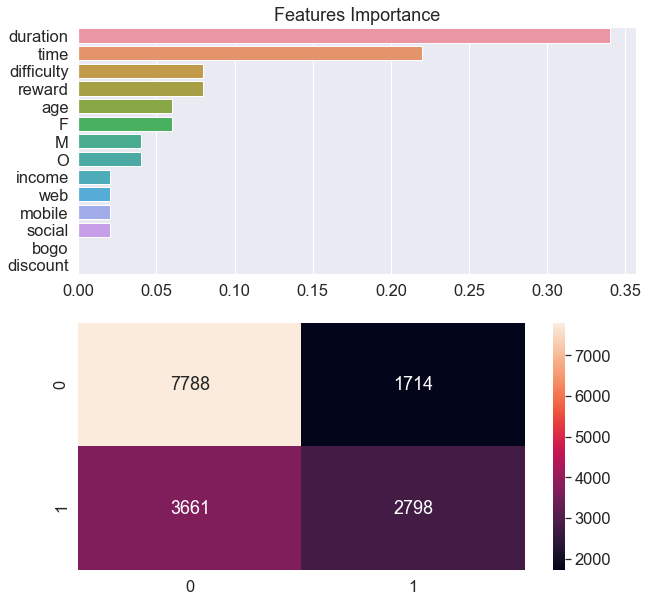

In [643]:
#execute the classification model with the AdaBoostClassifier
abc = classification_model(final_df, 'sucess', AdaBoostClassifier(random_state=42))

In [542]:
#get model params keys
model = AdaBoostClassifier(random_state=42)
model.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

#### As the best results were found using the Ada Boost Classifier and Gradient Boosting Classifier models, I tried to focus on these two to improve the accuracy of the algorithm a little. I reviewed the previous code and add a gridsearch to find the best parameters for each model.

#### Initially, I had selected different parameters and ranges to evaluate the best options. However, due to the processing time I opted for those options shown in the code below:

In [638]:
parameters_abc = {'n_estimators': [500, 1000, 1500],
                  'learning_rate': [0.1, 0.2, 0.5],
                  'algorithm': ['SAMME', 'SAMME.R'],
                 }

parameters_gbc = {'n_estimators': [25, 35, 40, 50, 100],
                  'learning_rate': [0.01, 0.015, 0.03, 0.045],
                  'min_samples_split': [2, 3, 4],
                  'min_samples_leaf': [1, 2, 3],
                  'max_depth': [3, 4, 5]
                 }


def model_best_params(df, target, model, parameters):
    '''
    Find the best parameters for the model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable ('sucess' column)
    parameters - dict with the model parameters
    
    OUTPUT:
    model - the classification model with best parameters
    '''
    
    #selecting the features do analyse   
    X = df[['offer_type', 'duration', 'time', 'difficulty', 'reward',
            'age', 'F', 'M', 'O', 'income',
            'web', 'mobile', 'social']]
    
    #create dummies for all offers
    offer_dummies = pd.get_dummies(X['offer_type'])
    
    #insert the offers dummies and drop the offer_type column
    X = pd.concat([X.drop('offer_type', axis=1), offer_dummies], axis=1)
    
    #set the target column - it should be the 'Sucess'
    y = df[target]
    
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #select the model, parameters and setting the grid
    model = model
    parameters = parameters
    
    grid = GridSearchCV(estimator=model,
                        param_grid=parameters,
                        cv=3,
                        verbose=3,
                        n_jobs=-1)
    
    #fit and predict
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, y_pred)))
    print("Overall model F1-Score:\t {}".format(f1_score(y_test, y_pred)))
    print('Best Params: ', grid.best_params_)
    
    
    return model

In [544]:
#find best parameters for adaboost classifier
model_best_params(final_df, 'sucess', AdaBoostClassifier(random_state=42), parameters_abc)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.44      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6633669569575841
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 1500}


AdaBoostClassifier(random_state=42)

In [636]:
#find best parameters for gradient classifier
model_best_params(final_df, 'sucess', GradientBoostingClassifier(random_state=42), parameters_gbc)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.48      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6670634672013032
Best Params:  {'learning_rate': 0.045, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


GradientBoostingClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.44      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6633669569575841
Overall model F1-Score:	 0.5135355364418289
Train ROC AUC score:	 0.7065750067372544
Test ROC AUC score:	 0.7082652297449037
kfold Accuracy: 66.19% (2.65%)


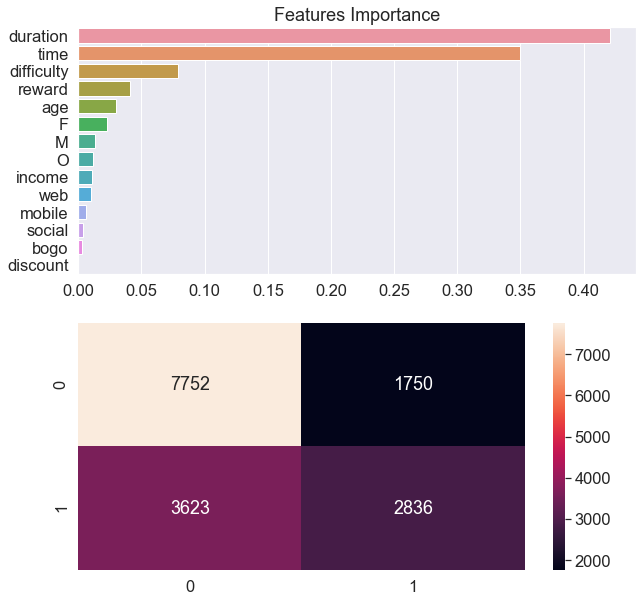

In [646]:
#execute the classification model with the AdaBoostClassifier using the best parameters
abc_opt = classification_model(final_df, 'sucess', AdaBoostClassifier(n_estimators=1500,
                                                                      learning_rate=.2,
                                                                      random_state=42))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.48      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6670634672013032
Overall model F1-Score:	 0.5406293222683264
Train ROC AUC score:	 0.7196815252236451
Test ROC AUC score:	 0.7168123258183209
kfold Accuracy: 66.64% (2.66%)


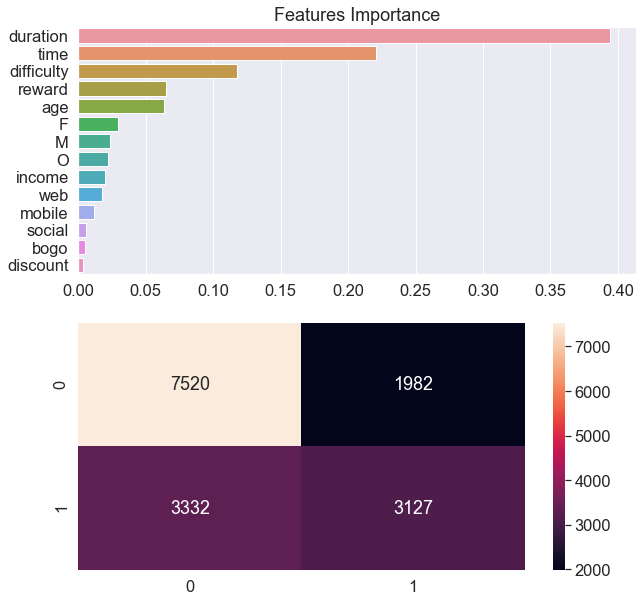

In [642]:
#execute the classification model with the GradientBoostingClassifier using the best parameters
gbc_opt = classification_model(final_df, 'sucess', GradientBoostingClassifier(min_samples_split=2,
                                                                              n_estimators=100,
                                                                              learning_rate=0.045,
                                                                              max_depth=4,
                                                                              min_samples_leaf=1,
                                                                              random_state=42))

## Conclusion
<p> The biggest challenge of this project was to do the correct data cleaning and understand the best way to define a successful offer. Separating the offers to identify 100% of the cases that actually followed the expected pattern for success previously defined is quite complex, especially in the way in which the data are arranged. </p>

<p> Analyzing the users, income and offers distributions, we can see that despite the female audience being smaller than the male, women tend to be more attentive to offers and have an average conversion rate higher than men. In addition, the offers that had the highest success rate did not necessarily bring a greater return for the company. It's important to know the campaing strategy - focusing on increasing revenue, increase the app traffic, etc... </p>

<p> Also by analyzing the correlation matrix more deeply, we can identify that the Social and Mobile channels were most related with offers visualization than others channels. Therefore, it is recommended that the company focus more on then in future campaigns.</p>

<p> Moving to the classification models, the focus was on evaluating which of the three proposed models would present the best solution. Among then, the one that obtained the best result was the Gradient Boosting Classifier with an overall accuracy of 0.67% and although low, the result is satisfactory.</p>

## **Some improvements!**
<p> Some improvements!
I believe that with more demographic information from clients, such as - city, profession or feedback - it would be possible to propose better strategies and find better results. In addition, the classification models could have benefited from more user transactions in the database.</p>
<p>Also it would be good to check and improve the sucess/unsucess formula used for bogo and discount offers with a more robust method and include the informational offers by seeting clear metrics for them.</p>
<p>Another aproach would be optimze the model using others gradient boosting algorithms such as XGBoost or CatBoost. They are improvised versions of the Gradient Bosting Classifier. Looking at the XGBoost one of the most important points is that it implements parallel preprocessing (at the node level) which makes it faster than GBM also includes a variety of regularization techniques that reduce overfitting and improve overall performance. For the CatBoost it works well with the default set of hyperparameters and can internally handle categorical variables in the data.</p>